# 1. Importing Libraries

In [1]:
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from mlxtend.plotting import plot_learning_curves
from mlxtend.data import mnist_data
from mlxtend.preprocessing import shuffle_arrays_unison

from imblearn.over_sampling import RandomOverSampler

from utils import createFeatures, listPeopleArticle

# 2. Loading the Data Set

In [2]:
'''path = r"data_motion/hw_dataset/control/"

for list in os.walk(path):
    path_control = list'''

path_control = [
    'data_motion/hw_dataset/control/C_0001.txt',
    'data_motion/hw_dataset/control/C_0002.txt',
    'data_motion/hw_dataset/control/C_0003.txt',
    'data_motion/hw_dataset/control/C_0004.txt',
    'data_motion/hw_dataset/control/C_0005.txt',
    'data_motion/hw_dataset/control/C_0006.txt',
    'data_motion/hw_dataset/control/C_0007.txt',
    'data_motion/hw_dataset/control/C_0008.txt',
    'data_motion/hw_dataset/control/C_0009.txt',
    'data_motion/hw_dataset/control/C_0010.txt',
    'data_motion/hw_dataset/control/C_0011.txt',
    'data_motion/hw_dataset/control/C_0012.txt',
    'data_motion/hw_dataset/control/C_0013.txt',
    'data_motion/hw_dataset/control/C_0014.txt',
    'data_motion/hw_dataset/control/C_0015.txt'
]

In [3]:
'''path = r"data_motion/hw_dataset/parkinson/"

for list in os.walk(path):
    path_parkinson = [list]

path = r"data_motion/new_dataset/parkinson/"

for list in os.walk(path):
    path_parkinson = list'''

path_parkinson = [
    'data_motion/hw_dataset/parkinson/P_02100001.txt',
    'data_motion/hw_dataset/parkinson/P_02100002.txt',
    'data_motion/hw_dataset/parkinson/P_05060003.txt',
    'data_motion/hw_dataset/parkinson/P_05060004.txt',
    'data_motion/hw_dataset/parkinson/P_09100001.txt',
    'data_motion/hw_dataset/parkinson/P_09100003.txt',
    'data_motion/hw_dataset/parkinson/P_09100005.txt',
    'data_motion/hw_dataset/parkinson/P_11120003.txt',
    'data_motion/hw_dataset/parkinson/P_11120004.txt',
    'data_motion/hw_dataset/parkinson/P_11120005.txt',
    'data_motion/hw_dataset/parkinson/P_12060001.txt',
    'data_motion/hw_dataset/parkinson/P_12060002.txt',
    'data_motion/hw_dataset/parkinson/P_16100003.txt',
    'data_motion/hw_dataset/parkinson/P_16100004.txt',
    'data_motion/hw_dataset/parkinson/P_23100002.txt',
    'data_motion/hw_dataset/parkinson/P_23100003.txt',
    'data_motion/hw_dataset/parkinson/P_26060001.txt',
    'data_motion/hw_dataset/parkinson/P_26060002.txt',
    'data_motion/hw_dataset/parkinson/P_26060003.txt',
    'data_motion/hw_dataset/parkinson/P_26060006.txt',
    'data_motion/hw_dataset/parkinson/P_26060007.txt',
    'data_motion/hw_dataset/parkinson/P_27110001.txt',
    'data_motion/hw_dataset/parkinson/P_27110003.txt',
    'data_motion/hw_dataset/parkinson/P_30100001.txt',
    'data_motion/hw_dataset/parkinson/P_30100002.txt',
    'data_motion/new_dataset/parkinson/H_P000-0001.txt',
    'data_motion/new_dataset/parkinson/H_P000-0002.txt',
    'data_motion/new_dataset/parkinson/H_P000-0003.txt',
    'data_motion/new_dataset/parkinson/H_P000-0004.txt',
    'data_motion/new_dataset/parkinson/H_P000-0007.txt',
    'data_motion/new_dataset/parkinson/H_P000-0008.txt',
    'data_motion/new_dataset/parkinson/H_p000-0010.txt',
    'data_motion/new_dataset/parkinson/H_P000-0011.txt',
    'data_motion/new_dataset/parkinson/H_P000-0012.txt',
    'data_motion/new_dataset/parkinson/H_P000-0013.txt',
    'data_motion/new_dataset/parkinson/H_P000-0014.txt',
    'data_motion/new_dataset/parkinson/H_P000-0015.txt',
    'data_motion/new_dataset/parkinson/H_P000-0016.txt',
    'data_motion/new_dataset/parkinson/H_p000-0017.txt',
    'data_motion/new_dataset/parkinson/H_p000-0018.txt',
    'data_motion/new_dataset/parkinson/H_P000-0019.txt',
    'data_motion/new_dataset/parkinson/H_P000-0020.txt',
    'data_motion/new_dataset/parkinson/H_P000-0021.txt',
    'data_motion/new_dataset/parkinson/H_P000-0022.txt',
    'data_motion/new_dataset/parkinson/H_P000-0023.txt',
    'data_motion/new_dataset/parkinson/H_P000-0024.txt',
    'data_motion/new_dataset/parkinson/H_P000-0025.txt',
    'data_motion/new_dataset/parkinson/H_p000-0028.txt',
    'data_motion/new_dataset/parkinson/H_P000-0029.txt',
    'data_motion/new_dataset/parkinson/H_P000-0030.txt',
    'data_motion/new_dataset/parkinson/H_P000-0031.txt',
    'data_motion/new_dataset/parkinson/H_P000-0032.txt',
    'data_motion/new_dataset/parkinson/H_P000-0033.txt',
    'data_motion/new_dataset/parkinson/H_P000-0034.txt',
    'data_motion/new_dataset/parkinson/H_P000-0035.txt',
    'data_motion/new_dataset/parkinson/H_P000-0036.txt',
    'data_motion/new_dataset/parkinson/H_P000-0037.txt',
    'data_motion/new_dataset/parkinson/H_P000-0039.txt',
    'data_motion/new_dataset/parkinson/H_P000-0040.txt',
    'data_motion/new_dataset/parkinson/H_p000-0041.txt',
    'data_motion/new_dataset/parkinson/H_p000-0042.txt',
    'data_motion/new_dataset/parkinson/H_p000-0043.txt'
]

# 3. Computing Features

In [4]:
Fs = 133

In [5]:
listControl_0 = listPeopleArticle(path_control, Fs, 0)
listParkinson_0 = listPeopleArticle(path_parkinson, Fs, 0)
listControl_1 = listPeopleArticle(path_control, Fs, 1)
listParkinson_1 = listPeopleArticle(path_parkinson, Fs, 1)
listControl_2 = listPeopleArticle(path_control, Fs, 2)
listParkinson_2 = listPeopleArticle(path_parkinson, Fs, 2)

In [6]:
listControl_0, controlDiagnoses_0 = createFeatures(listControl_0, 0)
listParkinson_0, parkinsonDiagnoses_0 = createFeatures(listParkinson_0, 1)
listControl_1, controlDiagnoses_1 = createFeatures(listControl_1, 0)
listParkinson_1, parkinsonDiagnoses_1 = createFeatures(listParkinson_1, 1)
listControl_2, controlDiagnoses_2 = createFeatures(listControl_2, 0)
listParkinson_2, parkinsonDiagnoses_2 = createFeatures(listParkinson_2, 1)

# 4. Visualizing the Data Info

In [7]:
print(f"Número de pessoas saudáveis no TestID 0: {listControl_0.shape[0]}")
print(f"Número de pessoas saudáveis no TestID 1: {listControl_1.shape[0]}")
print(f"Número de pessoas saudáveis no TestID 2: {listControl_2.shape[0]}")
print(f"Número de pessoas saudáveis no total: {listControl_0.shape[0]+listControl_1.shape[0]+listControl_2.shape[0]}")

Número de pessoas saudáveis no TestID 0: 15
Número de pessoas saudáveis no TestID 1: 15
Número de pessoas saudáveis no TestID 2: 0
Número de pessoas saudáveis no total: 30


In [8]:
print(f"Número de pessoas com Parkinson no TestID 0: {listParkinson_0.shape[0]}")
print(f"Número de pessoas com Parkinson no TestID 1: {listParkinson_1.shape[0]}")
print(f"Número de pessoas com Parkinson no TestID 2: {listParkinson_2.shape[0]}")
print(f"Número de pessoas com Parkinson no total: {listParkinson_0.shape[0]+listParkinson_1.shape[0]+listParkinson_2.shape[0]}")

Número de pessoas com Parkinson no TestID 0: 61
Número de pessoas com Parkinson no TestID 1: 57
Número de pessoas com Parkinson no TestID 2: 36
Número de pessoas com Parkinson no total: 154


In [9]:
listPerson = pd.concat([listControl_0, listParkinson_0,listControl_1,listParkinson_1,listControl_2,listParkinson_2])
listDiagnoses = np.concatenate([controlDiagnoses_0, parkinsonDiagnoses_0,controlDiagnoses_1,parkinsonDiagnoses_1,controlDiagnoses_2, parkinsonDiagnoses_2])

In [10]:
zero = 0
um = 0
for i in range(len(listDiagnoses)):
    if listDiagnoses[i]==0:
        zero += 1
    else:
        um += 1
        
print(f'Paciêntes sem Parkinson = {zero}')
print(f"Paciêntes com Parkinson = {um}")

Paciêntes sem Parkinson = 30
Paciêntes com Parkinson = 154


# 5. Applying Oversampling

In [11]:
ros = RandomOverSampler(random_state=0)
ros.fit(listPerson, listDiagnoses)
listPerson, listDiagnoses= ros.fit_resample(listPerson, listDiagnoses)

In [12]:
zero = 0
um = 0
for i in range(len(listDiagnoses)):
    if listDiagnoses[i]==0:
        zero += 1
    else:
        um += 1

print(f'Paciêntes sem Parkinson = {zero}')
print(f"Paciêntes com Parkinson = {um}")

Paciêntes sem Parkinson = 154
Paciêntes com Parkinson = 154


In [13]:
pd.set_option('display.max_rows', None)

In [14]:
#display(listPerson)

###### 6. Process of Classifying

### 6.1. Applying Cross-Validation to Split the Data

In [15]:
#n_splits = len(listPerson)
n_splits = 10

In [16]:
kf = KFold(n_splits=n_splits,shuffle=True)

In [17]:
kf.get_n_splits()

10

### 6.2. Classification Algorithms Used:

- K-Nearest Neighbors
- Decision Tree
- Random Forest

In [21]:
rfc = RandomForestClassifier()

# Number of trees in random forest
n_tree = [int(x) for x in np.linspace(start = 5, stop = 100, num = 5)]
# To measure the quality of a split
criterion = ['gini', 'entropy', 'log_loss']
# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_tree,
              'criterion': criterion,
              'max_features': max_features,
              'bootstrap': bootstrap}

rfc = GridSearchCV(estimator = rfc, param_grid = param_grid,cv = 3)

x_train, x_test, y_train, y_test = train_test_split(listPerson, listDiagnoses, test_size=1/n_splits)

ss = StandardScaler()

x_train = ss.fit_transform(x_train, y=y_train)
x_train = pd.DataFrame(x_train, columns = ['velocityWeighted','pressureWeighted','CISP'])
x_test = ss.transform(x_test)
x_test = pd.DataFrame(x_test, columns = ['velocityWeighted','pressureWeighted','CISP'])

rfc.fit(x_train, y_train)
rfc_param = rfc.best_params_

In [22]:
rfc_param

{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 'log2',
 'n_estimators': 5}

In [23]:
knnc = KNeighborsClassifier()
cartc = DecisionTreeClassifier()
rfc = RandomForestClassifier(**rfc_param)

### 6.3. Training and Testing Phase

In [24]:
TP_TN_FP_FN = np.zeros((3,4))

diagnoses = []
guesseddiagnosesknn = []
guesseddiagnosesdt = []
guesseddiagnosesrf = []

for train_index, test_index in kf.split(listPerson,y=listDiagnoses):
    
    x_train, x_test = listPerson.iloc[train_index], listPerson.iloc[test_index]
    y_train, y_test = listDiagnoses[train_index], listDiagnoses[test_index]
    
    x_train= ss.fit_transform(x_train, y=y_train)
    x_train = pd.DataFrame(x_train, columns = ['velocityWeighted','pressureWeighted','CISP'])
    x_test = ss.fit_transform(x_test, y=y_test)
    x_test = pd.DataFrame(x_test, columns = ['velocityWeighted','pressureWeighted','CISP'])
    
    
    knnc_trained = knnc.fit(x_train, y_train)
    cartc_trained = cartc.fit(x_train, y_train)
    rfc_trained = rfc.fit(x_train, y_train)
    
    
    
    modelsc = [knnc_trained, cartc_trained, rfc_trained]

    j = 0
    diagnoses.append(y_test[:])
    for model in modelsc:
        predict = model.predict(x_test)
        if model == modelsc[0]:
            guesseddiagnosesknn.append(model.predict(x_test))
        elif model == modelsc[1]:
            guesseddiagnosesdt.append(model.predict(x_test))
        else:
            guesseddiagnosesrf.append(model.predict(x_test))
        
        for i in range(y_test.shape[0]):
            if y_test[i] == 0 and predict[i] == 0:
                TP_TN_FP_FN[j][1] +=1
            elif y_test[i] == 1 and predict[i] == 1:
                TP_TN_FP_FN[j][0] +=1
            elif y_test[i] == 1 and predict[i] == 0:
                TP_TN_FP_FN[j][3] +=1
            elif y_test[i] == 0 and predict[i] == 1:
                TP_TN_FP_FN[j][2] +=1
        j+=1
    


### 6.4. Computing Results

##### 6.4.1 Accuracy, Sensibility and Specificity Result

In [25]:
acc = np.empty(3)
sens = np.empty(3)
esp = np.empty(3)
for i in range(3):
    TP,TN,FP,FN = TP_TN_FP_FN[i]
    acc[i] = ((TP+TN)/(TP+TN+FN+FP)*100)
    sens[i] = ((TP)/(TP+FN)*100)
    esp[i] = ((TN)/(TN+FP)*100)

In [26]:
mod = ['KNN','DecisionTree','RandomForest']
nam = ['acurácia','sensibilidade','especificidade']
for i in range(3):
    print(f'{mod[i]} sua {nam[0]} é de {np.round(acc[i],2)}%')
for i in range(3):
    print(f'{mod[i]} sua {nam[1]} é de {np.round(sens[i],2)}%')
for i in range(3):
    print(f'{mod[i]} sua {nam[2]} é de {np.round(esp[i],2)}%')

KNN sua acurácia é de 81.82%
DecisionTree sua acurácia é de 64.94%
RandomForest sua acurácia é de 67.53%
KNN sua sensibilidade é de 75.32%
DecisionTree sua sensibilidade é de 87.66%
RandomForest sua sensibilidade é de 90.91%
KNN sua especificidade é de 88.31%
DecisionTree sua especificidade é de 42.21%
RandomForest sua especificidade é de 44.16%


##### 6.4.2. Confusion Matrix Result

##### K-Nearest Neighbors

In [27]:
cm_knn = [[0,0],[0,0]]
for i in range(len(diagnoses)):
    cm_knn += confusion_matrix(diagnoses[i],guesseddiagnosesknn[i])

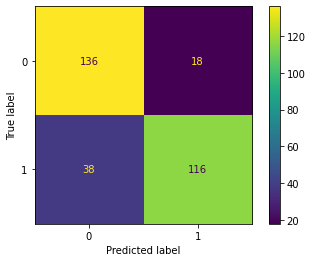

In [28]:
disp_knn = ConfusionMatrixDisplay(cm_knn)
disp_knn.plot()
plt.show()

##### Decision Tree

In [29]:
cm_dt = [[0,0],[0,0]]
for i in range(len(diagnoses)):
    cm_dt += confusion_matrix(diagnoses[i],guesseddiagnosesdt[i])

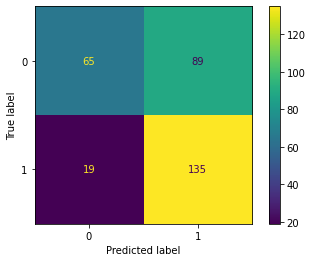

In [30]:
disp_dt = ConfusionMatrixDisplay(cm_dt)
disp_dt.plot()
plt.show()

##### Random Forest

In [31]:
cm_rf = [[0,0],[0,0]]
for i in range(len(diagnoses)):
    cm_rf += confusion_matrix(diagnoses[i],guesseddiagnosesrf[i])

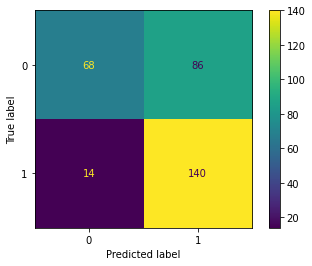

In [32]:
disp_rf = ConfusionMatrixDisplay(cm_rf)
disp_rf.plot()
plt.show()

##### 6.4.3. Learning Curve Result

In [33]:
#KNN
kn_train_sizes, kn_train_scores, kn_test_scores = learning_curve(KNeighborsClassifier(), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 50), verbose=1)

#DecisionTree
dt_train_sizes, dt_train_scores, dt_test_scores = learning_curve(DecisionTreeClassifier(), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 50), verbose=1)

#RandomForest
rf_train_sizes, rf_train_scores, rf_test_scores = learning_curve(RandomForestClassifier(), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 50), verbose=1)


[learning_curve] Training set sizes: [  2   7  12  17  22  27  32  37  42  47  53  58  63  68  73  78  83  88
  93  98 103 108 113 118 123 128 133 138 143 148 154 159 164 169 174 179
 184 189 194 199 204 209 214 219 224 229 234 239 244 250]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [  2   7  12  17  22  27  32  37  42  47  53  58  63  68  73  78  83  88
  93  98 103 108 113 118 123 128 133 138 143 148 154 159 164 169 174 179
 184 189 194 199 204 209 214 219 224 229 234 239 244 250]


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [  2   7  12  17  22  27  32  37  42  47  53  58  63  68  73  78  83  88
  93  98 103 108 113 118 123 128 133 138 143 148 154 159 164 169 174 179
 184 189 194 199 204 209 214 219 224 229 234 239 244 250]


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.1s finished


In [34]:
#KNN
kn_train_mean = np.mean(kn_train_scores, axis=1)
kn_train_mean

kn_train_std = np.std(kn_train_scores, axis=1)
kn_train_std

kn_test_mean = np.mean(kn_test_scores, axis=1)
kn_test_mean

kn_test_std = np.std(kn_test_scores, axis=1)
kn_test_std

#DecisionTree
dt_train_mean = np.mean(dt_train_scores, axis=1)
dt_train_mean

dt_train_std = np.std(dt_train_scores, axis=1)
dt_train_std

dt_test_mean = np.mean(dt_test_scores, axis=1)
dt_test_mean

dt_test_std = np.std(dt_test_scores, axis=1)
dt_test_std

#RandomForest
rf_train_mean = np.mean(rf_train_scores, axis=1)
rf_train_mean

rf_train_std = np.std(rf_train_scores, axis=1)
rf_train_std

rf_test_mean = np.mean(rf_test_scores, axis=1)
rf_test_mean

rf_test_std = np.std(rf_test_scores, axis=1)
rf_test_std


array([0.00828173, 0.00828173, 0.00828173, 0.14805866, 0.13559466,
       0.12977161, 0.11522523, 0.12667103, 0.1233698 , 0.14151189,
       0.09893305, 0.09797838, 0.1193371 , 0.12156193, 0.143122  ,
       0.142228  , 0.14680609, 0.1309169 , 0.15412772, 0.1499328 ,
       0.15243675, 0.1420064 , 0.15563905, 0.17173006, 0.15784924,
       0.16066333, 0.15701253, 0.16200442, 0.13066406, 0.09968851,
       0.08102335, 0.06585389, 0.06196197, 0.05813864, 0.0557875 ,
       0.05802885, 0.0510904 , 0.05357143, 0.04844521, 0.03846546,
       0.03642157, 0.04240836, 0.03976975, 0.0457366 , 0.04285714,
       0.03846546, 0.04295257, 0.0457366 , 0.03970039, 0.04857668])

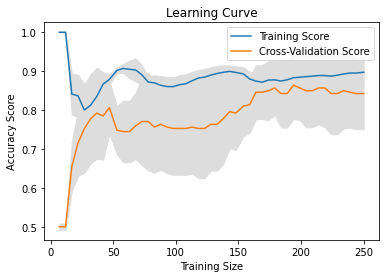

In [35]:
#KNN
plt.plot(kn_train_sizes, kn_train_mean, label='Training Score')
plt.plot(kn_train_sizes, kn_test_mean, label='Cross-Validation Score')

plt.fill_between(kn_train_sizes, kn_train_mean-kn_train_std, kn_train_mean+kn_train_std, color='#DDDDDD')
plt.fill_between(kn_train_sizes, kn_test_mean-kn_test_std, kn_test_mean+kn_test_std, color='#DDDDDD')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc = 'best')


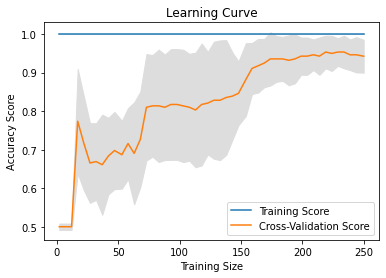

In [36]:
#DecisionTree
plt.plot(dt_train_sizes, dt_train_mean, label='Training Score')
plt.plot(dt_train_sizes, dt_test_mean, label='Cross-Validation Score')

plt.fill_between(dt_train_sizes, dt_train_mean-dt_train_std, dt_train_mean+dt_train_std, color='#DDDDDD')
plt.fill_between(dt_train_sizes, dt_test_mean-dt_test_std, dt_test_mean+dt_test_std, color='#DDDDDD')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc = 'best')


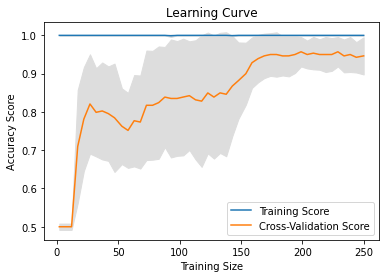

In [37]:
#RandomForest
plt.plot(rf_train_sizes, rf_train_mean, label='Training Score')
plt.plot(rf_train_sizes, rf_test_mean, label='Cross-Validation Score')

plt.fill_between(rf_train_sizes, rf_train_mean-rf_train_std, rf_train_mean+rf_train_std, color='#DDDDDD')
plt.fill_between(rf_train_sizes, rf_test_mean-rf_test_std, rf_test_mean+rf_test_std, color='#DDDDDD')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc = 'best')

##### 6.4.4 Validation Curves

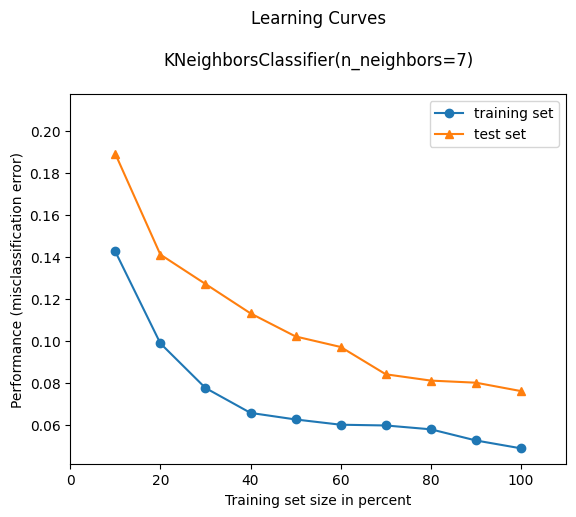

In [43]:
x_test, y = mnist_data()
x_test, y = shuffle_arrays_unison(arrays=[x_test, y], random_seed=123)
X_train, X_test = x_test[:4000], x_test[4000:]
y_train, y_test = y[:4000], y[4000:]

clf = KNeighborsClassifier(n_neighbors=7)

plot_learning_curves(X_train, y_train, X_test, y_test, clf)
plt.show()
